In [1]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns

 from pathlib import Path 
 Path(path).mkdir(exist_ok=True, parents=True)


In [2]:
from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

In [3]:
def make_fn(case, v_x, v_y, comment=''):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'dist_plots_to2015_f09_{comment}_{case}_{_x}_{_y}.png'
    return plot_path /f



In [4]:
plot_path = Path('Plots')

In [5]:
xr.set_options(keep_attrs=True) 

## Get observational data

In [6]:
import pandas as pd

In [7]:
from bs_fdbck.constants import measurements_path

In [8]:
fn = measurements_path /'SourceData_Yli_Juuti2021.xls'

df_hyy_1 = pd.read_excel(fn, sheet_name=4, header=1,)# usecols=range(7,12),nrows=7)

df_hyy_1.head()
#df_hyy_1y= df_hyy_1y.rename({'year.1':'year',
#                            'T (degree C).1':'T (degree C)',
#                             'OA (microgram m^-3).1':'OA (microgram m^-3)',
#                             'N100 (cm^-3).1':'N100 (cm^-3)'
#                            }, axis=1)
#df_hyy_1y['year'] = pd.to_datetime(df_hyy_1y['year'].apply(x:str(x)))

df_hyy_1

,year,month,day,LAT,LON,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
0,2012,7,5,60.5,22.5,3.218589,191,12.940000,26.219999
1,2012,7,10,60.5,22.5,4.714353,172,10.950000,24.430000
2,2012,7,14,60.5,22.5,1.451827,106,15.790000,12.030000
3,2012,7,19,60.5,22.5,3.101941,262,16.039999,28.650000
4,2012,7,22,60.5,22.5,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
3668,2018,8,13,65.5,29.5,0.674785,191,15.200000,18.969999
3669,2018,8,14,65.5,29.5,1.356364,291,15.200000,31.449999
3670,2018,8,19,65.5,29.5,0.916047,139,18.230000,11.960000
3671,2018,8,20,65.5,29.5,1.325436,177,14.049999,19.869999


In [9]:
import pandas as pd

In [10]:
df_hyy_1['date'] = df_hyy_1.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_1['date'] = pd.to_datetime(df_hyy_1['date'] )

In [11]:
df_hyy_1 = df_hyy_1.set_index(['date','LAT','LON'])

In [12]:
df_hyy_1

,,,year,month,day,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
date,LAT,LON,,,,,,,
2012-07-05,60.5,22.5,2012,7,5,3.218589,191,12.940000,26.219999
2012-07-10,60.5,22.5,2012,7,10,4.714353,172,10.950000,24.430000
2012-07-14,60.5,22.5,2012,7,14,1.451827,106,15.790000,12.030000
2012-07-19,60.5,22.5,2012,7,19,3.101941,262,16.039999,28.650000
2012-07-22,60.5,22.5,2012,7,22,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
2018-08-13,65.5,29.5,2018,8,13,0.674785,191,15.200000,18.969999
2018-08-14,65.5,29.5,2018,8,14,1.356364,291,15.200000,31.449999
2018-08-19,65.5,29.5,2018,8,19,0.916047,139,18.230000,11.960000


In [13]:
#df_hyy_1['OA_category']

df_hyy_1['OA_low'] = df_hyy_1['OA (microgram m^-3)']<2
df_hyy_1['OA_high']= df_hyy_1['OA (microgram m^-3)']>2
ddf_hyy_1=df_hyy_1.assign(OA_category= pd.NA)
df_hyy_1.loc[df_hyy_1['OA_high'], 'OA_category'] = 'OA high'
df_hyy_1.loc[df_hyy_1['OA_low'], 'OA_category'] = 'OA low'



In [14]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

In [15]:
labels=[ 80, 120, 160, 200, 240, 280, 320]

In [16]:
df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 6)#bins=bins, labels=labels)

In [17]:
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)

df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)

<AxesSubplot:ylabel='Frequency'>

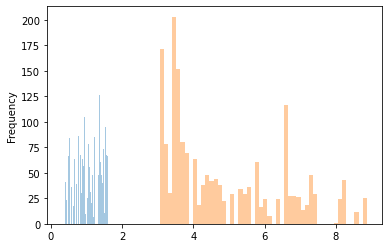

In [18]:
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_high']].plot.hist(bins=50, alpha=0.4, label='obs')



## Get model data:

### Settings

In [19]:
lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

In [20]:
temperature = 273.15  # K

In [21]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_full'

In [22]:
fn = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0.nc'
fn_comb_lev1 = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1.nc'
fn_comb_lev1_final = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final.nc'
fn_comb_lev1_final_csv = path_extract_latlon_outdata/ case_name/f'{case_name}.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final.csv'

In [23]:

cases = [case_name]

In [24]:
varl =['DOD500','DOD440','ACTREL','ACTNL','TGCLDLWP', #,'SOA_A1',
       'H2SO4','SOA_LV','COAGNUCL','FORMRATE','T'
       ,'FCTL',
       'TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP',
       'CLDFREE',
      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3', 
       'FSDSC','FSDSCDRF'
      ]

## Station variables

In [25]:
varl_st = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
                 ]


varl_cl = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
           'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

## If file not already createad already, skip this part

In [26]:
fn_comb_lev1.exists()

True

In [27]:
if not fn_comb_lev1.exists():
    ds_mod = xr.open_dataset(fn, chunks = {'time':48})#[fn1,fn2])#.sortby('time')
    #ds_mod2 = xr.open_dataset(fn2, chunks = {'time':48})

    ds_mod = compute_total_tau(ds_mod)

    ds_mod = ds_mod.sortby('time')#.sel(time=slice('2012','2014'))

    ds_mod = ds_mod.isel(lev = model_lev_i)


    delayed_obj = ds_mod.to_netcdf(fn_comb_lev1, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

## If file createad already, skip to here

### Select hyytiala grid cell:

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [28]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb_lev1).isel(ilev=model_lev_i)
    ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
        #ilev=-1,
        # cosp_tau_modis=0,
        #                                                    cosp_tau=0,
        #                                                   cosp_dbze=0,
        #                                                    cosp_ht=0,
        #                                                    cosp_prs = 0,
        #                                                   cosp_reffice=0,
        #                                                    cosp_htmisr=0,
        #                                                    cosp_reffliq=0,
        #                                                    cosp_scol=0,
        #                                                    cosp_sr=0,
        #                                                    cosp_sza=0,
        nbnd=0
    ).squeeze()
    ds_all = broadcase_station_data(ds_all)
    ds_all = change_units_and_compute_vars(ds_all, temperature=temperature)


    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

### Broadcast ds_sel to same grid

In [29]:

ds_all = xr.open_dataset(fn_comb_lev1_final)

In [30]:
dic_ds = dict()
dic_ds[case_name] =ds_all

In [31]:
if not fn_comb_lev1_final_csv.exists():
    dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True)

    df_mod = dic_df[case_name]
    df_mod.to_csv(fn_comb_lev1_final_csv)

In [32]:
df_mod = pd.read_csv(fn_comb_lev1_final_csv, index_col=[0,1,2] )

## Clean data:

### Remove gridcells that don't have a lot of cloud?

In [33]:
df_mod = df_mod[df_mod['CLDFREE']<.5]#.index.get_level_values(1)

### Remove grid vells with no cloud top liquid

In [34]:
mask_liq_cloudtop = df_mod['FCTL']>0.1

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop

<AxesSubplot:xlabel='time'>

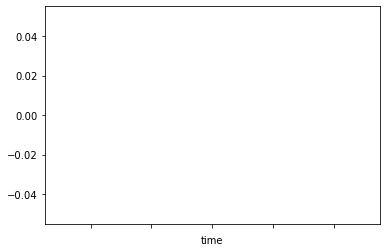

In [35]:
one_gc = (df_mod.index.get_level_values(1)==61.57894736842104) & (df_mod.index.get_level_values(2) ==30.0)

_ma = mask_liq_cloudtop[one_gc]

df_mod[one_gc][_ma].reset_index().set_index('time')['FCTL'].plot()#ylim=[-.0,.01])

In [36]:
df_mod = df_mod[df_mod['mask_liq_cloudtop']]

## Group by cloud water path

In [37]:
df_mod['CWP_qcut']=pd.qcut(df_mod['TGCLDCWP'],6)# bins=bins, labels=labels)§

df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)



In [38]:
bins = pd.IntervalIndex.from_breaks([ 10,  40,  70,  100, 130, 160, 190,500])


df_mod['CWP_cut']=pd.cut(df_mod['TGCLDCWP'], bins=bins)#, labels=labels)

df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)

## Category of OA concentration

In [39]:
df_mod['OA_low'] = df_mod['OA']<df_mod['OA'].quantile(.34)
df_mod['OA_high']= df_mod['OA']>df_mod['OA'].quantile(.66)

In [40]:
#df_mod['OA_low'].loc[:,:] = df_mod['OA']<df_mod['OA'].quantile(.34)
mid_range = ( df_mod['OA'].quantile(.34)<df_mod['OA']) & (df_mod['OA']<df_mod['OA'].quantile(.66))
df_mod['OA_mid_range'] = mid_range

In [41]:

df_mod=df_mod.assign(OA_category= pd.NA)
df_mod.loc[df_mod['OA_high'], 'OA_category'] = 'OA high'
df_mod.loc[df_mod['OA_low'], 'OA_category'] = 'OA low'



## Distribution plots:

In [42]:
palette = 'Set2'

In [43]:
import numpy as np

In [44]:
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [46]:
#cmap = cm.get_cmap(name=palette, )
#rgba = cmap(0.1)
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

In [47]:
palette_OA = cmap_list[0:2]

3673
442


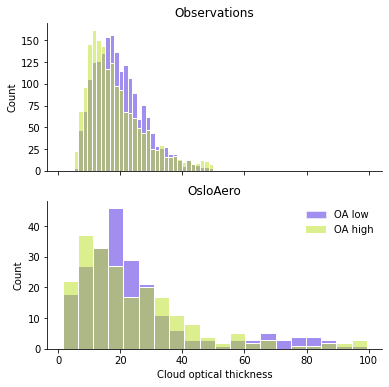

In [48]:
fig, axs = plt.subplots(2,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


_df = df_hyy_1
_df = _df[_df[v_x]<x_cut]

ax = axs[0]
sns.histplot(#x='TGCLDLWP',
            x=v_x,
            data=_df,
            hue=v_hue,
    hue_order=hue_order,
    palette=_palette,
    legend=False,
    edgecolor='w',

    ax = ax
           )
#plt.ylim([0,250])
print(len(_df))
ax.set_title('Observations')


v_x = 'TOT_ICLD_VISTAU_s'
ax = axs[1]

_df = (df_mod[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]<x_cut]
sns.histplot(#x='TGCLDLWP',
            x=v_x,
            data=_df,
            hue=v_hue,
    hue_order=hue_order,
    ax = ax,
    legend=False,

    palette = _palette,
    edgecolor='w',

           #kind='swarm'
           )
ax.set_title('OsloAero')

custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn(case_name, v_x,'obs',comment='distribution')

fig.savefig(fn, dpi=150)



3673
450


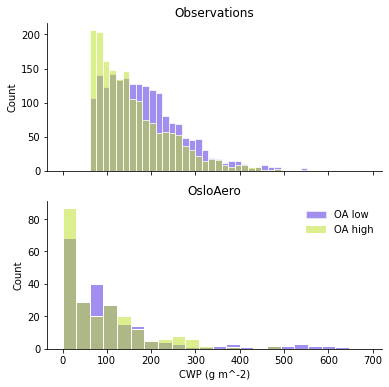

In [49]:
fig, axs = plt.subplots(2,1, sharex=True, figsize =[6,6])
v_x = 'CWP (g m^-2)'
x_cut = 10e10
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


_df = df_hyy_1
_df = _df[_df[v_x]<x_cut]

ax = axs[0]
sns.histplot(
    x=v_x,
    data=_df,
    hue=v_hue,
    hue_order=hue_order,
    palette=_palette,
    legend=False,
    edgecolor='w',
    ax = ax
)
print(len(_df))
ax.set_title('Observations')


v_x = 'TGCLDCWP_incld'
ax = axs[1]

_df = (df_mod[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]<x_cut]
sns.histplot(
    x=v_x,
    data=_df,
    hue=v_hue,
    hue_order=hue_order,
    ax = ax,
    legend=False,
    palette = _palette,
    edgecolor='w',
)

ax.set_title('OsloAero')

custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('CWP (g m^-2)')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn(case_name, v_x,'obs',comment='distribution')

fig.savefig(fn, dpi=150)



3673
450


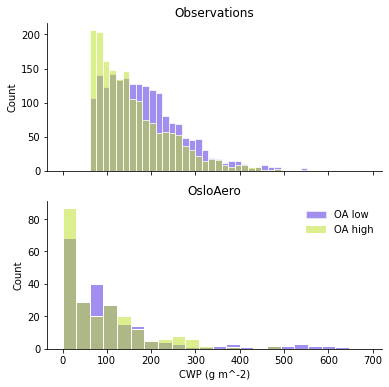

In [50]:
fig, axs = plt.subplots(2,1, sharex=True, figsize =[6,6])
v_x = 'CWP (g m^-2)'
x_cut = 10e10
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


_df = df_hyy_1
_df = _df[_df[v_x]<x_cut]

ax = axs[0]
sns.histplot(
    x=v_x,
    data=_df,
    hue=v_hue,
    hue_order=hue_order,
    palette=_palette,
    legend=False,
    edgecolor='w',
    ax = ax
)
print(len(_df))
ax.set_title('Observations')


v_x = 'TGCLDCWP_incld'
ax = axs[1]

_df = (df_mod[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]<x_cut]
sns.histplot(
    x=v_x,
    data=_df,
    hue=v_hue,
    hue_order=hue_order,
    ax = ax,
    legend=False,
    palette = _palette,
    edgecolor='w',
)

ax.set_title('OsloAero')

custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('CWP (g m^-2)')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn(case_name, v_x,'obs',comment='distribution')

fig.savefig(fn, dpi=150)



### Fractional occurance of cloud top liquid

450


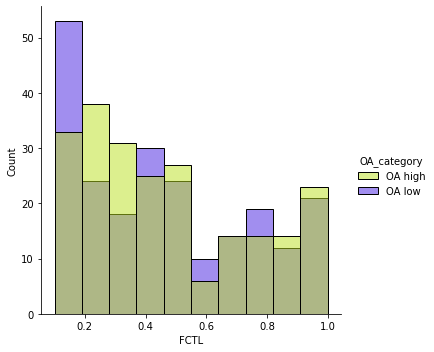

In [51]:
_df = df_mod#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP',
            x='FCTL',
            data=_df,
            hue='OA_category',
    palette=palette_OA,
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

### Take only points where 30% of cloud top is liquid

450


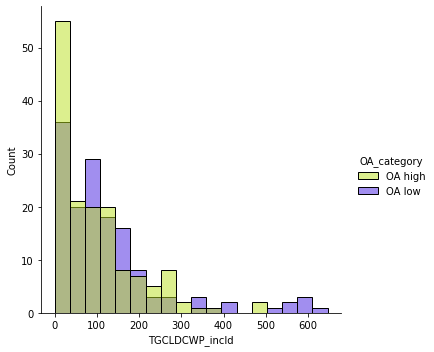

In [52]:
_df = df_mod
_df = _df[_df['FCTL']>.3]
sns.displot(
    x='TGCLDCWP_incld',
    data=_df,
    hue='OA_category',
    palette=palette_OA,
)
print(len(df_mod[df_mod['OA_category'].notna()]))

486


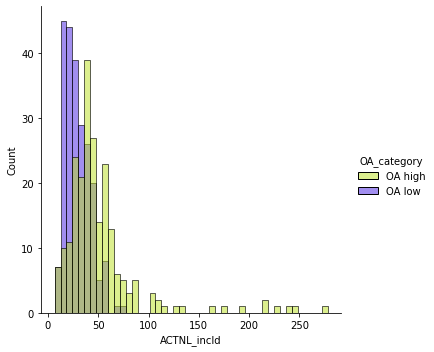

In [53]:
sns.displot(
    x='ACTNL_incld',
    data=df_mod[~df_mod['OA_mid_range']].reset_index(),
    hue='OA_category',
    palette=palette_OA,
)
print(len(df_mod[~df_mod['OA_mid_range']]))

## Cloud optical thickness

### Incloud

In [54]:
hue_order = ['OA low','OA high']
palette_OA_2 = palette_OA[::-1]

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 65.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 54.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


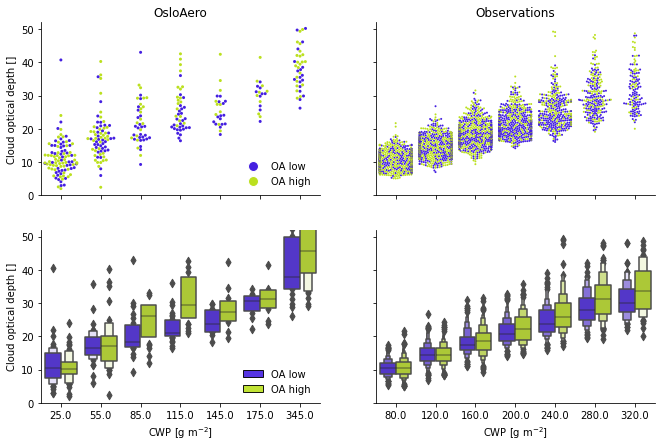

In [55]:
x_mod = 'CWP_cutl'
x_obs = 'CWP_cutl'
y_mod = 'TOT_ICLD_VISTAU_s'
y_obs = 'COT'
ylim = [0,52]
figsize = [12,10]
figsize = [11,7]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex='col')

markersize= 2

_df_obs = df_hyy_1#df_mod[df_mod['OA_category'].notna()].reset_index()
_df_obs_lim =_df_obs[(_df_obs[y_obs]<=ylim[1])& (_df_obs[y_obs]>=ylim[0])]


ax = axs[0,1]
sns.swarmplot(
    x=x_obs,
    y=y_obs,
    data=_df_obs_lim,
    hue_order=hue_order,
    hue='OA_category',
    palette=_palette,
    size = markersize,
    ax = ax,
)


ax = axs[1,1]
sns.boxenplot(
    x=x_obs,
    y=y_obs,
    data= _df_obs,
    hue_order=hue_order,#['OA low','OA high'],
    hue='OA_category',
    #kind='boxen',
    ax = ax,
    palette=_palette,
           )


## PLOT MODEL



_df_mod = df_mod[df_mod['OA_category'].notna()].reset_index()
_df_mod_lim =_df_mod[(_df_mod[y_mod]<=ylim[1])& (_df_mod[y_mod]>=ylim[0])]

markersize=3
ax = axs[0,0]
sns.swarmplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod_lim,
    hue_order=hue_order,

    hue='OA_category',
    palette=_palette,
    ax = ax,
    size = markersize,
)


ax = axs[1,0]
sns.boxenplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod,
    hue_order=hue_order,

    ax = ax,
    hue='OA_category',
    palette=_palette,
)


## ADJUSTMENTS

leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label='OA low'),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label='OA high'),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label='OA low'
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label='OA high'
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)


for ax in axs[:,1]:
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)
for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)


axs[0,0].set_title('OsloAero')
axs[0,1].set_title('Observations')

sns.despine(fig)

fn = make_fn(case_name, x_mod,y_mod, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 65.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 54.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


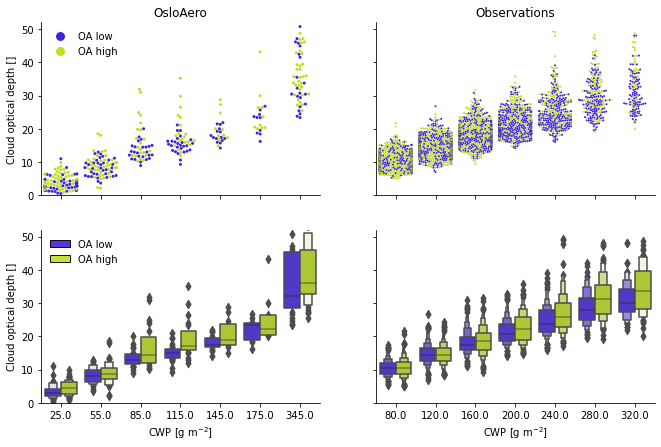

In [56]:
x_mod = 'CWP_cutl'
x_obs = 'CWP_cutl'
y_mod = 'TOT_CLD_VISTAU_s'
y_obs = 'COT'
ylim = [0,52]
figsize = [12,10]
figsize = [11,7]

_palette = palette_OA_2

fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex='col')


markersize= 2

_df_obs = df_hyy_1#df_mod[df_mod['OA_category'].notna()].reset_index()
_df_obs_lim =_df_obs[(_df_obs[y_obs]<=ylim[1])& (_df_obs[y_obs]>=ylim[0])]


ax = axs[0,1]
sns.swarmplot(
    x=x_obs,
    y=y_obs,
    data=_df_obs_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    size = markersize,
    ax = ax,
)


ax = axs[1,1]
sns.boxenplot(
    x=x_obs,
    y=y_obs,
    data= _df_obs,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    #kind='boxen',
    ax = ax,
    palette=_palette,
           )


## PLOT MODEL



_df_mod = df_mod[df_mod['OA_category'].notna()].reset_index()
_df_mod_lim =_df_mod[(_df_mod[y_mod]<=ylim[1])& (_df_mod[y_mod]>=ylim[0])]

markersize=3
ax = axs[0,0]
sns.swarmplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    ax = ax,
    size = markersize,
)


ax = axs[1,0]
sns.boxenplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod,
    hue_order=['OA low','OA high'],
    ax = ax,
    hue='OA_category',
    palette=_palette,
)


## ADJUSTMENTS

leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label='OA low'),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label='OA high'),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label='OA low'
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label='OA high'
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)


for ax in axs[:,1]:
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)
for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)

axs[0,0].set_title('OsloAero')
axs[0,1].set_title('Observations')


sns.despine(fig)

fn = make_fn(case_name, x_mod,y_mod, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


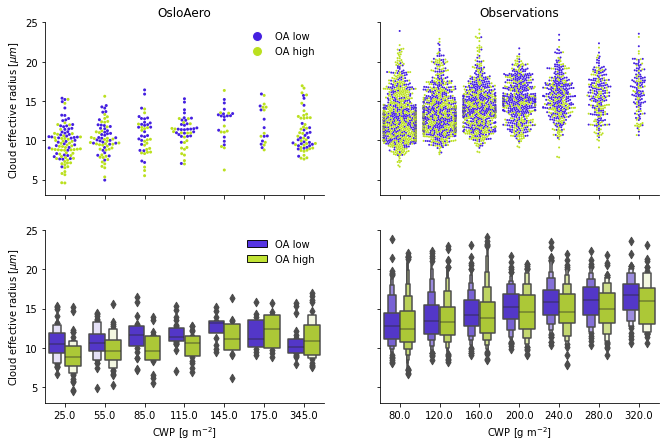

In [57]:
x_mod = 'CWP_cutl'
x_obs = 'CWP_cutl'
y_mod = 'ACTREL_incld'
y_obs = 'CER (micrometer)'
ylim = [3,25]
figsize = [11,7]
_palette = palette_OA_2
fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex='col')

markersize= 2

_df_obs = df_hyy_1#df_mod[df_mod['OA_category'].notna()].reset_index()
_df_obs_lim =_df_obs[(_df_obs[y_obs]<=ylim[1])& (_df_obs[y_obs]>=ylim[0])]




_df_mod = df_mod[df_mod['OA_category'].notna()].reset_index()
_df_mod_lim =_df_mod[(_df_mod[y_mod]<=ylim[1])& (_df_mod[y_mod]>=ylim[0])]



# OBSERVATIONS PLOT

ax = axs[0,1]
sns.swarmplot(
    x=x_obs,
    y=y_obs,
    data=_df_obs_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    size = markersize,
    ax = ax,
)


ax = axs[1,1]
sns.boxenplot(
    x=x_obs,
    y=y_obs,
    data= _df_obs,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    #kind='boxen',
    ax = ax,
    palette=_palette,
           )


## PLOT MODEL

markersize=3
ax = axs[0,0]
sns.swarmplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    ax = ax,
    size = markersize,
)


ax = axs[1,0]
sns.boxenplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod,
    hue_order=['OA low','OA high'],
    ax = ax,
    hue='OA_category',
    palette=_palette,
)


## ADJUSTMENTS

leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label='OA low'),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label='OA high'),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label='OA low'
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label='OA high'
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)


for ax in axs[:,1]:
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)
for ax in axs[:,0]:
    ax.set_ylabel('Cloud effective radius [$\mu m$]')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)


axs[0,0].set_title('OsloAero')
axs[0,1].set_title('Observations')

sns.despine(fig)

fn = make_fn(case_name, x_mod,y_mod, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


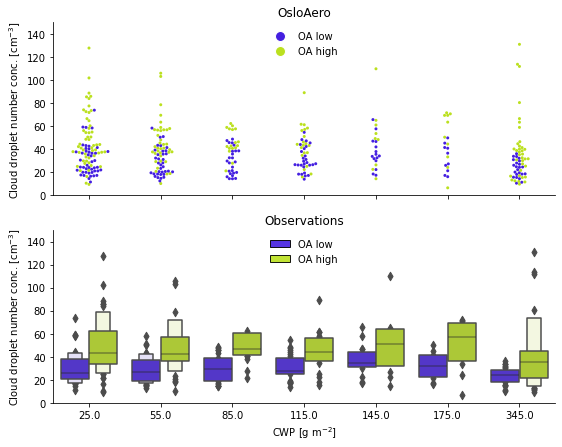

In [58]:
x_mod = 'CWP_cutl'
y_mod = 'ACTNL_incld'
ylim = [0,150]
figsize = [9,7]
_palette = palette_OA_2

fig, axs = plt.subplots(2,1,figsize=figsize, sharey=True, sharex='col')

markersize= 2

_df_obs = df_hyy_1
_df_obs_lim =_df_obs[(_df_obs[y_obs]<=ylim[1])& (_df_obs[y_obs]>=ylim[0])]

_df_mod = df_mod[df_mod['OA_category'].notna()].reset_index()
_df_mod_lim =_df_mod[(_df_mod[y_mod]<=ylim[1])& (_df_mod[y_mod]>=ylim[0])]



## PLOT MODEL

markersize=3
ax = axs[0]
sns.swarmplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    ax = ax,
    size = markersize,
)


ax = axs[1]
sns.boxenplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod,
    hue_order=['OA low','OA high'],
    ax = ax,
    hue='OA_category',
    palette=_palette,
)


## ADJUSTMENTS

leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label='OA low'),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label='OA high'),
          ]
axs[1].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label='OA low'
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label='OA high'
           ),
          ]
axs[0].legend(handles = leg_els, frameon=False)


#for ax in axs[:,1]:
#    ax.legend([],[], frameon=False)
#    ax.set_ylabel(None)
for ax in axs:
    ax.set_ylabel(r'Cloud droplet number conc. [cm$^{-3}$]')
for ax in axs:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[:-1]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)

axs[0].set_title('OsloAero')
axs[1].set_title('Observations')


sns.despine(fig)

fn = make_fn(case_name, x_mod,y_mod, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg